# "Deploying a Machine Learning Model Tutorial"
> "This tutorial is all about deploying a real machine learning model. More precisely, we will deploy a computer vision model trained to detect common objects in pictures."

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [jupyter]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

# Deploying a Machine Learning Model Tutorial

This tutorial is all about deploying a real machine learning model. More precisely, we will deploy a computer vision model trained to detect common objects in pictures. Deploying a model is one of the last steps in a machine learning workflow. This tutorial uses a pretrained model called [`YOLOV3`](https://pjreddie.com/darknet/yolo/). You only look once (YOLO) is a state-of-the-art, real-time object detection system. The model is fast and accurate. Moreover, you can easily tradeoff between speed and accuracy simply by changing the size of the model, no retraining required!

The tasks in this tutorial are as follow:
1. Exploring the images in the data set
2. Analyzing the YOLO model
3. Deploy the model using [`fastAPI`](https://fastapi.tiangolo.com/)

## Object Detection with YOLOV3

### Exploring the images in the data set

This will give us an insight on what type of common objects are present for detection. These images are part of the [`ImageNet`](http://www.image-net.org/index) dataset.

In [1]:
#collapse-hide
import cv2
import cvlib as cv
import os

from cvlib.object_detection import draw_bbox
from IPython.display import Image, display

2021-07-29 16:52:28.884576: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-29 16:52:28.884604: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


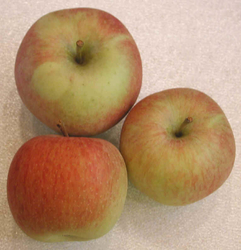


Displaying image: apples.jpg


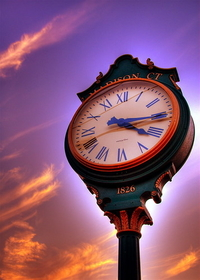


Displaying image: clock2.jpg


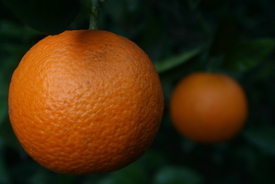


Displaying image: oranges.jpg


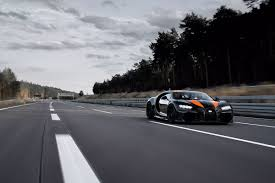


Displaying image: car1.jpg


In [2]:
#collapse-hide
# Sample images
image_data = [
    'apples.jpg',
    'clock2.jpg',
    'oranges.jpg',
    'car1.jpg'
]

for image in image_data:
    display(Image(filename=f"images/{image}"))
    print(f"\nDisplaying image: {image}")

### Overview of the model

For this tutorial, we are using [`cvlib`](https://www.cvlib.net/), a simple, high level, easy-to-use open source Computer Vision library for Python.

We are using the [`detect_common_objects`](https://docs.cvlib.net/object_detection/) function, for example: `detect_common_objects(image, confidence=0.5, nms_thresh=0.3, model='yolov3', enable_gpu=False)` which takes an image as a [`numpy array`](https://numpy.org/doc/stable/reference/generated/numpy.array.html) and returns:

- `bbox`: list of list containing bounding box coordinates for detected objects. 

- `label`: list of labels for detected objects.

- `conf`: list of confidence scores for detected objects.

### Defining the detect_and_draw_box_on_image function

Before using the object detection model, we need to create a directory where we can store the resulting image objects:

In [3]:
#collapse-hide
dir_name = "draw_box_images"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

The `detect_and_draw_box_on_image` function takes as input arguments: the **imput image**, a **model**, and a **confidence level**. The function detects common objects in the image and saves a new image displaying the bounding boxes with the detected image object.

The confidence level argument, determines the threshold that the probability needs to reach to report that a given object is detected on the provided image. By default, `detect_common_objects` uses a value of 0.5 for this, but here we are a confidence level value of 0.4. 

In [4]:
#collapse-hide
def detect_and_draw_box_on_image(filename, model="yolov3-tiny", confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". Defaults to "yolov3-tiny".
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    
    # Images are stored under the images/ directory
    image_path = f'images/{filename}'
    
    # Read the image into a numpy array
    image = cv2.imread(image_path)
    
    # Perform the object detection
    bounding_box, label, confidence = cv.detect_common_objects(image, confidence=confidence, model=model)
    
    # Print current image's filename
    print(f"========================\nImage processed: {filename}\n")
    
    # Print detected objects with confidence level
    for level, conf in zip(label, confidence):
        print(f"Detected object: {level} with confidence level of {conf}\n")
    
    # Create a new image that includes the bounding boxes
    output_image = draw_bbox(image, bounding_box, label, confidence)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'draw_box_images/{filename}', output_image)
    
    # Display the image with bounding boxes
    display(Image(f'draw_box_images/{filename}'))

Image processed: apples.jpg

Detected object: apple with confidence level of 0.9589297771453857

Detected object: apple with confidence level of 0.9145920872688293

Detected object: orange with confidence level of 0.6645317077636719



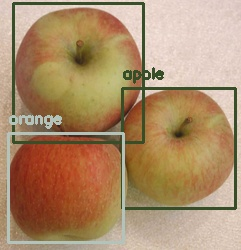

Image processed: clock2.jpg

Detected object: clock with confidence level of 0.7303982377052307



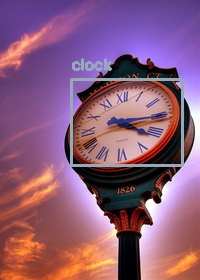

Image processed: oranges.jpg

Detected object: orange with confidence level of 0.6185590624809265

Detected object: orange with confidence level of 0.5561691522598267



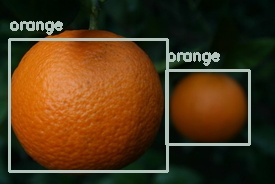

Image processed: car1.jpg

Detected object: car with confidence level of 0.9725152254104614



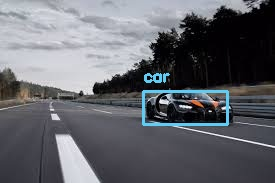

In [5]:
#collapse-hide
for image in image_data:
    detect_and_draw_box_on_image(image)

## Tuning the confidence level

Looks like the object detection went fairly well. Let us try the model with an image containing many image objects:

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818483829498291

Detected object: orange with confidence level of 0.5346482992172241

Detected object: orange with confidence level of 0.515099287033081



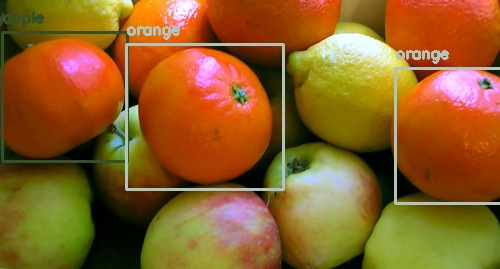

In [6]:
#collapse-hide
detect_and_draw_box_on_image("fruits.jpg")

With several images, the model seems to misclassified an orange as an apple. Let us try with a confidence level of 0.2. 

By changing the confidence level to a value of 0.2, the model is able to detects successfully most the images. However, in practice, we need to be careful when changing this value, as this might yield undesired results. 

## Deploying the model using fastAPI

In [7]:
#collapse-hide
dir_name = "images_uploaded"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

### Creating an instance of the fastAPI using the client-server model
With fastAPI we can create web servers to host your models very easily. Additionally, this platform is extremely fast and it **has a built-in client that can be used to interact with the server**. To use it you will need to visit the "/docs" endpoint, for this case this means to visit http://localhost:8000/docs. 

In [8]:
#collapse-hide
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [9]:
#collapse-hide
# Assign an instance of the FastAPI class to the variable "app".
# You will interact with your api using this instance.
app = FastAPI(title='Deploying a ML Model with FastAPI')

# List available models using Enum for convenience. This is useful when the options are pre-defined.
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"


# By using @app.get("/") you are allowing the GET method to work for the / endpoint.
@app.get("/")
def home():
    return "Congratulations! Your API is working as expected. Now head over to http://localhost:8000/docs."


# This endpoint handles all the logic necessary for the object detection to work.
# It requires the desired model and the image in which to perform object detection.
@app.post("/predict") 
def prediction(model: Model, file: UploadFile = File(...)):

    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    # 3. RUN OBJECT DETECTION MODEL
    
    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, model=model)
    
    # Create image that includes bounding boxes and labels
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Save it in a folder within the server
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    
    # 4. STREAM THE RESPONSE BACK TO THE CLIENT
    
    # Open the saved image for reading in binary mode
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")

By running the following cell you will spin up the server!

This causes the notebook to block (no cells/code can run) until you manually interrupt the kernel. You can do this by clicking on the `Kernel` tab and then on `Interrupt`. You can also enter Jupyter's command mode by pressing the `ESC` key and tapping the `I` key twice.

In [ ]:
#collapse-hide
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# Host depends on the setup you selected (docker or virtual env)
host = "0.0.0.0" if os.getenv("DOCKER-SETUP") else "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=8000)

The server is now running! Head over to [http://localhost:8000/](http://localhost:8000/) to see it in action.

**Try submitting an image** and see how your API is able to detect objects within it and return a new image containing the bounding boxes alongside the labels of the detected objects. **You can do this by  visiting [http://localhost:8000/docs](http://localhost:8000/docs) to open fastAPI's built-in client.** 

When doing so you will get a screen that should look like the one below, follow the instructions next:

Click on top of the `/predict` endpoint and more options will become visible:

#hide
![image.png](attachment:image.png)

To test your server click on the **Try it out** button.

#hide
![image.png](attachment:image.png)

Be careful when choosing the model, because if you select the full YOLO model, it might take a while download the model, which is bigger than the YOLO-tiny model. 

**Submit an image** from your local filesystem by clicking the **Choose File** button, then click on the blue **Execute** button to send an HTTP request to the server. After doing so, **scroll down and you will see the response from it**. 

#hide
![image.png](attachment:image.png)

## Consuming the model from another client

It is possible to interact with the model API using a different client, which look next. However, the server need to be running when using the client. 